In [14]:

# coding: utf-8

# In[30]:

import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import math
import cv2


# In[31]:

df = pd.read_csv("training.csv")
df.dropna(inplace=True)
sample = df.shape[0]
df["Image"] = df["Image"].apply(lambda im: np.fromstring(im, sep=' '))
x = np.vstack(np.array(df["Image"])).reshape(sample, 96, 96)
#normaliation done
x = x/255
y = df.drop(columns="Image").as_matrix()
print (x.shape)

def image_points(ser):
    plt.imshow(ser["Image"].reshape(96, 96), cmap="gray")
    ser = ser.values[0:30]
    for i in range(15):
        plt.scatter(ser[2*i], ser[2*i+1], c='r', s=40)

def image_x_y(x, y):
    plt.imshow(x, cmap="gray")
    for i in range(15):
        plt.scatter(y[2*i], y[2*i+1], c='r', s=40)

def mir_y(input_y):
    temp = np.copy(input_y)
    for i in range(30):
        if (i+1)%2:
            temp[i] = 96 - input_y[i]
    return temp

def HistogramStretching(image):
    # a, b = min(image), max(image)
    a, b = np.percentile(image, 5), np.percentile(image, 95)
    l, u = 0, 1
    const = 1.0*(b*l - a*u)/(b - a)
    k = 1.0*(u-l)/(b-a)
    return [k*p+const for p in image]

def rotate_p(x,y,a, x0=48, y0=48):
    x2 = ((x - x0) * np.cos(a)) - ((y - y0) * np.sin(a)) + x0
    y2 = ((x - x0) * np.sin(a)) + ((y - y0) * np.cos(a)) + y0
    return (x2, y2)

def rotate_img(img, a):
    M = cv2.getRotationMatrix2D((48,48),a,1)
    dst = np.copy(cv2.warpAffine(img,M,(96,96)))
    return dst

def rotate_yp(n, a):
    t = []
    for i in range(15):
        nx, ny = rotate_p(n[2*i], n[2*i+1], a)
        t.append(nx)
        t.append(ny)
    return t

def rotate(x, y, a):
    # a in degrees
    nimg = rotate_img(x, a)
    ny = rotate_yp(y, -1*(np.pi/6)*(a/30.0))
    return (nimg, ny)


(2140, 96, 96)


In [18]:
nx = []
for i in x:
    nx.append(cv2.resize(i, (32, 32)))
x = np.array(nx)
print x.shape

(2140, 32, 32)


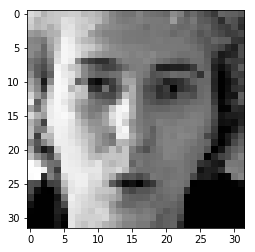

In [20]:
%matplotlib inline
plt.imshow(x[1], cmap='gray')

In [16]:
print resized_image.shape

(32, 32, 96)


In [2]:
x = x[:200]
y = y[:200]
sample = 200
print x.shape, y.shape

(200, 96, 96) (200, 30)


In [3]:

#q = df.loc[randint(0, df.shape[0])]
#image_points(q)
x_translate = []
y_translate = []
for i in range(x.shape[0]):
    min_px = 95
    max_px = 2
    min_py = 95
    max_py = 2
    for p in range(15):
        min_px = min(min_px, y[i][2*p])
        max_px = max(max_px, y[i][2*p])
        min_py = min(min_py, y[i][2*p+1])
        max_py = max(max_py, y[i][2*p+1])
    
    max_py = max_py-1
    max_px = max_px-1
    min_px = min_px+1
    min_py = min_py+1
    
    for _ in range(4):
        ht = np.random.randint(2)
        vt = np.random.randint(2)

        if ht==0:
            mx = -1*np.random.randint(min_px)
        else:
            mx = np.random.randint(96-max_px)

        if vt==0:
            my = -1*np.random.randint(min_py)
        else:
            #print (max_py)
            my = np.random.randint(96-max_py)

        M = np.float32([[1, 0, mx], [0, 1, my]])
        x_translate.append(np.copy(cv2.warpAffine(x[i], M, (96, 96))))
        
        #plt.imshow(cv2.warpAffine(x[i], M, (96, 96)), cmap='gray')

        y_t = np.copy(y[i])
        for p in range(15):
            y_t[2*p] = y[i][2*p]+mx
            y_t[2*p+1] = y[i][2*p+1]+my

        y_translate.append(y_t)

x_rotate = []
y_rotate = []
for i in range(x.shape[0]):
    for _ in range(4):
        a = np.random.randint(-90,90)
        
        nx, ny = rotate(x[i], y[i], a)
        
        min_px = 95
        max_px = 2
        min_py = 95
        max_py = 2
        for p in range(15):
            min_px = min(min_px, ny[2*p])
            max_px = max(max_px, ny[2*p])
            min_py = min(min_py, ny[2*p+1])
            max_py = max(max_py, ny[2*p+1])

        max_py = max_py-1
        max_px = max_px-1
        min_px = min_px+1
        min_py = min_py+1
        
        if max_py>96 or max_px>96 or min_px<0 or min_py<0:
            continue
        
        
        x_rotate.append(nx)
        y_rotate.append(ny)

x_rotate = np.array(x_rotate)
y_rotate = np.array(y_rotate)
np.random.shuffle(x_rotate)
np.random.shuffle(y_rotate)
x_rotate = x_rotate[:3*sample]
y_rotate = y_rotate[:3*sample]
print (x_rotate.shape, y_rotate.shape)

# In[ ]:




((600, 96, 96), (600, 30))


In [4]:
# data agumentation 12x
x_all = np.ndarray((sample*15, 96, 96), float)
y_all = np.ndarray((sample*15, 30), float)

# Original
x_all[0*sample:1*sample, :, :] = np.copy(x)
y_all[0*sample:1*sample, :] = np.copy(y)

# Brightness thrice 0.7 1.3 1.6
x_all[1*sample:2*sample, :, :] = 0.7*np.copy(x)
y_all[1*sample:2*sample, :] = np.copy(y)

x_all[2*sample:3*sample, :, :] = np.copy(np.where(1.3*x>1, 1, 1.3*x))
y_all[2*sample:3*sample, :] = np.copy(y)

x_all[3*sample:4*sample, :, :] = np.copy(np.where(1.6*x>1, 1, 1.6*x))
y_all[3*sample:4*sample, :] = np.copy(y)

# histogram stretching
x_all[4*sample:5*sample, :, :] = np.copy([HistogramStretching(i) for i in x])
y_all[4*sample:5*sample, :] = np.copy(y)

# gaussian blur
x_all[5*sample:6*sample, :, :] = np.copy([cv2.GaussianBlur(i,(5,5),0) for i in x])
y_all[5*sample:6*sample, :] = np.copy(y)

# mirror + blur + brightness
x_all[6*sample:7*sample, :, :] = np.copy([cv2.flip(cv2.GaussianBlur(np.where(1.6*i>1, 1, 1.6*i),(5,5),0),1) for i in x])
y_all[6*sample:7*sample, :] = np.copy([mir_y(i) for i in y])

# translate
x_all[7*sample:11*sample, :, :] = np.copy(x_translate)
y_all[7*sample:11*sample, :] = np.copy(y_translate)

# rotate
x_all[11*sample:14*sample, :, :] = np.copy(x_rotate)
y_all[11*sample:14*sample, :] = np.copy(y_rotate)

# Mirror
for i in range(sample):
    x_all[14*sample+i, :, :] = cv2.flip(x[i,:, :], 1)
    y_all[14*sample+i, :] = np.copy(mir_y(y[i]))

# In[34]:



In [11]:
print x_all.shape
x_all = x_all[:200]

(3000, 9216)


In [12]:

x_all = x_all.reshape(-1,96*96)
mean, eg = cv2.PCACompute(x_all, mean=None)
x_all = eg[:,:256]
x_all = x_all.reshape(-1, 16, 16)
print (x_all.shape)

(200, 16, 16)


In [13]:
print eg[0]

[-0.00802694 -0.00803133 -0.00834015 ... -0.0008761  -0.00111637
 -0.00098765]


In [7]:
x_all = x_all.reshape(-1,96*96)
pca = PCA(copy=True,whiten=False)
pca.fit(x_all)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
p = (pca.components_)
print p[0]

[0.01305204 0.0128829  0.01275697 ... 0.00794419 0.00819215 0.00824365]


In [ ]:

x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.2, random_state = 1)
# theano and tensorflow have different channel order

x_train = x_train.reshape(x_train.shape[0], 16, 16, 1)
x_val = x_val.reshape(x_val.shape[0], 16, 16, 1)
input_shape = (16, 16, 1)
    
print('x_train shape', x_train.shape)
print('x_val shape', x_val.shape)


In [ ]:
# In[35]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,[None,16,16,1])
Y = tf.placeholder(tf.float32,[None,30])
is_training = tf.placeholder(tf.bool)
l2_loss = tf.constant(0.0)

#Convolution layer 1
w_conv1 = tf.get_variable("w_conv1",shape = [5,5,1,32])
b_conv1 = tf.get_variable("b_conv1",shape = [32])
z_conv1 = tf.nn.conv2d(X,w_conv1,strides = [1,1,1,1], padding='SAME')+b_conv1
print(z_conv1.shape)
a_conv1 = tf.nn.relu(z_conv1)
max_pool1 = tf.nn.max_pool(a_conv1,ksize=[1,2,2,1],strides=[1,2,2,1], padding='SAME')
drp1 = tf.nn.dropout(max_pool1,keep_prob = 0.3)

#Convolution layer 2
w_conv2 = tf.get_variable("w_conv2",shape = [3,3,32,8])
b_conv2 = tf.get_variable("b_conv2",shape = [8])
z_conv2 = tf.nn.conv2d(drp1,w_conv2,strides = [1,1,1,1], padding='SAME')+b_conv2
print(z_conv2.shape)
a_conv2 = tf.nn.relu(z_conv2)
max_pool2 = tf.nn.max_pool(a_conv2,ksize=[1,2,2,1],strides=[1,2,2,1], padding='SAME')
drp2 = tf.nn.dropout(max_pool2,keep_prob = 0.3)

flat1 = tf.reshape(drp2,[-1,128])

#Fully connected 
w_fc1 = tf.get_variable("w_fc1",shape = [128,100])
b_fc1 = tf.get_variable("b_fc1",shape = [100])
fc1 = tf.matmul(flat1,w_fc1)+b_fc1
a_fc1 = tf.nn.relu(fc1)

#fully connected 2
w_fc2 = tf.get_variable("w_fc2",shape = [100,30])
b_fc2 = tf.get_variable("b_fc2",shape = [30])
fc2 = tf.matmul(a_fc1,w_fc2)+b_fc2

print (Y.shape, fc2.shape)

loss = tf.sqrt(tf.reduce_sum((tf.losses.mean_squared_error(Y,fc2))))
#loss = tf.reduce_mean(tf.reduce_sum(tf.square(Y - fc2), 1))

optimizer = tf.train.AdamOptimizer(1e-2)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(loss)
#train_step = optimizer.minimize(loss)


In [ ]:
saver = tf.train.Saver(tf.global_variables())

def run_model(session, predict, loss_val, Xd, yd, Xval, yval,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=True, save_every=10):
    
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    variables = [loss_val, train_step]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            #print yd[idx[1:3]]
            #print idx
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx],
                         Y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g}"                      .format(iter_cnt,loss))
            iter_cnt += 1
        
        
        total_loss = np.sum(losses)/(int(math.ceil(Xd.shape[0]/batch_size)))
        print("Epoch {1}, Overall loss = {0:.3g}"              .format(total_loss,e+1))
        
        
        

        if e % save_every == 0:
            '''plt.gcf().set_size_inches(10, 4)
            
            plt.subplot(1,2,1)        
            # test a image
            print ("Testing..")
            n_t = np.random.randint(0, Xd.shape[0])
            x_t = Xd[n_t]
            y_t = session.run(predict, {X:Xd[n_t].reshape(1,96,96,1), is_training:False})
            image_x_y(x_t.reshape(96,96), y_t[0])
        
            plt.subplot(1,2,2)
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()'''
            
            # check loss on validation data
            feed_dict = {X: Xval,
                         Y: yval,
                         is_training: False}
            loss = session.run(loss_val,feed_dict=feed_dict)
            print ('val loss', loss)
            
            checkpoint_path = os.path.join('/output/', 'model')
            saver.save(sess, checkpoint_path)
            print("model saved to {}".format(checkpoint_path))
            with open('/output/checkpoint', "w") as raw:
                raw.write('model_checkpoint_path: "model"\nall_model_checkpoint_paths: "model"')

    
    return total_loss

In [ ]:
with tf.Session() as sess:
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,fc2,loss,x_train,y_train,x_val,y_val,2000,256,50,train_step,True)
        #print('Validation')
        #run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

